In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

In [31]:
tfp.distributions.Dirichlet([.8, 2.], validate_args=True).mean()

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.2857143 , 0.71428573], dtype=float32)>

In [32]:
tfp.distributions.DirichletMultinomial(10, [.8, 2.], validate_args=True).mean()

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.857143 , 7.1428576], dtype=float32)>

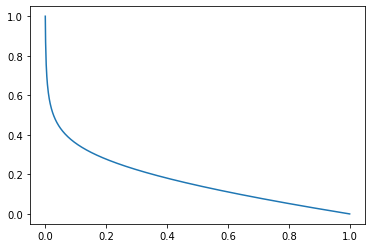

In [33]:
success = np.linspace(0.001, .999, num=1000)
failure = 1 - success
x = np.stack([success, failure], axis=1)
dirichlet_probs = tfp.distributions.Dirichlet([.8, 2.], validate_args=True).prob(x)
plt.plot(success, dirichlet_probs / dirichlet_probs.numpy().max())




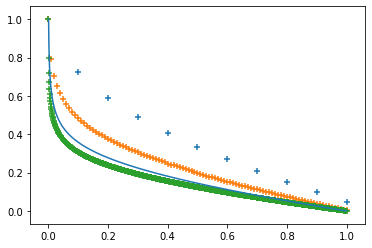

In [34]:
success = np.linspace(0.001, .999, num=1000)
failure = 1 - success
x = np.stack([success, failure], axis=1)
dirichlet_probs = tfp.distributions.Dirichlet([.8, 2.], validate_args=True).prob(x)
plt.plot(success, dirichlet_probs / dirichlet_probs.numpy().max())


n = 10
success = np.arange(0, n+1)
failure = n - success
x = np.stack([success, failure], axis=1)
multinomial_probs = tfp.distributions.DirichletMultinomial(n, [.8, 2.], validate_args=True).prob(x)
plt.scatter(success / n, multinomial_probs / multinomial_probs.numpy().max(), marker='+')

n = 100
success = np.arange(0, n+1)
failure = n - success
x = np.stack([success, failure], axis=1)
multinomial_probs = tfp.distributions.DirichletMultinomial(n, [.8, 2.], validate_args=True).prob(x)
plt.scatter(success / n, multinomial_probs / multinomial_probs.numpy().max(), marker='+')


n = 1000
success = np.arange(0, n+1)
failure = n - success
x = np.stack([success, failure], axis=1)
multinomial_probs = tfp.distributions.DirichletMultinomial(n, [.8, 2.], validate_args=True).prob(x)
plt.scatter(success / n, multinomial_probs / multinomial_probs.numpy().max(), marker='+')



As you ask more people, the pdf of the observed fraction approximates the pdf of the pure dirichlet distribution
ie. dirichlet multimonial approximates dirichlet for large N

For training the model, we want dirichlet-multinomial, to account for our uncertainty int he true labels
But for reporting our predictions, we want the dirichlet only, without the extra noise from how many people we ask.

Bounds reported on the dirichlet must correspond to the same bounds on dirichlet-multimonial at high N, because the distributions approximate each other at high N

In [35]:
from zoobot.estimators.dirichlet_stats import beta_confidence_interval

In [36]:
beta_confidence_interval(10, 30, interval_width=.8)

(0.14485585585585586, 0.3196806806806807)

In [37]:
beta_confidence_interval(1, 3, interval_width=.8)

(0.07192892892892894, 0.999)

In [38]:
beta_confidence_interval(2, 5, interval_width=.8)

(0.001, 0.4225775775775776)

In [39]:
from zoobot.estimators.dirichlet_stats import DirichletEqualMixture

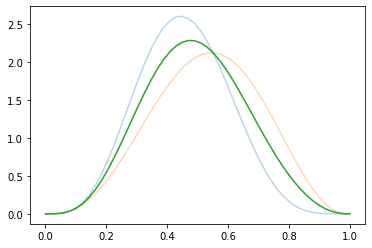

In [40]:
mixture_concentrations = np.array([[5., 4.], [6., 3.5]])
with_batch = np.expand_dims(mixture_concentrations, axis=0)
mixture = DirichletEqualMixture(with_batch)
successes = np.linspace(0., 1.)
x = np.stack([successes, 1-successes], axis=1)

probs = mixture.prob(x)
plt.plot(x[:, 0], probs, alpha=.3)

mean_probs = mixture.mean_prob(x)
plt.plot(x[:, 0], mean_probs)

In [41]:
mixture.distributions[0].prob(x)

<tf.Tensor: shape=(50,), dtype=float64, numpy=
array([0.00000000e+00, 1.97156914e-04, 2.83932494e-03, 1.29086255e-02,
       3.65517655e-02, 7.97534033e-02, 1.47418879e-01, 2.42797626e-01,
       3.67185106e-01, 5.19847332e-01, 6.98118039e-01, 8.97624192e-01,
       1.11260096e+00, 1.33626237e+00, 1.56119873e+00, 1.77977641e+00,
       1.98451988e+00, 2.16845993e+00, 2.32543559e+00, 2.45034086e+00,
       2.53931043e+00, 2.58984135e+00, 2.60085038e+00, 2.57266897e+00,
       2.50697980e+00, 2.40670061e+00, 2.27582255e+00, 2.11921142e+00,
       1.94238101e+00, 1.75124857e+00, 1.55188255e+00, 1.35025292e+00,
       1.15199434e+00, 9.62191459e-01, 7.85195475e-01, 6.24479492e-01,
       4.82539188e-01, 3.60843554e-01, 2.59838582e-01, 1.79004625e-01,
       1.16965650e-01, 7.16458743e-02, 4.04662711e-02, 2.05700761e-02,
       9.06288674e-03, 3.24904582e-03, 8.41866882e-04, 1.20822338e-04,
       4.10743571e-06, 0.00000000e+00])>

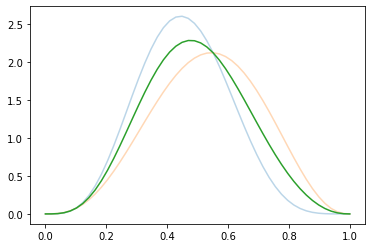

In [42]:
beta_mixture = mixture.to_beta(answer_index=1, batch_dim=len(successes))

x = successes
probs = beta_mixture.prob(x)
plt.plot(x, probs, alpha=.3)

mean_probs = beta_mixture.mean_prob(x)
plt.plot(x, mean_probs)

In [43]:
x.shape

(50,)

In [44]:
mixture.distributions[0], beta_mixture.distributions[0]

(<tfp.distributions.Dirichlet 'Dirichlet' batch_shape=[1] event_shape=[2] dtype=float64>,
 <tfp.distributions.Beta 'Beta' batch_shape=[50] event_shape=[] dtype=float32>)

In [45]:
beta_mixture.log_prob(x)

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[        -inf,         -inf],
       [ -8.531511  ,  -7.1853776 ],
       [ -5.86419   ,  -5.15857   ],
       [ -4.34986   ,  -3.9959407 ],
       [ -3.3090267 ,  -3.1878414 ],
       [ -2.5288162 ,  -2.5745926 ],
       [ -1.9144783 ,  -2.085102  ],
       [ -1.4155273 ,  -1.6814761 ],
       [ -1.0018902 ,  -1.3411255 ],
       [ -0.6542206 ,  -1.0495076 ],
       [ -0.35936737,  -0.796721  ],
       [ -0.10800457,  -0.57572937],
       [  0.10669994,  -0.3813653 ],
       [  0.28987598,  -0.20973492],
       [  0.44545364,  -0.05783844],
       [  0.57648754,   0.0766716 ],
       [  0.68537617,   0.19565487],
       [  0.77401686,   0.30059958],
       [  0.8439069 ,   0.39270306],
       [  0.8962264 ,   0.47292995],
       [  0.9318919 ,   0.5420561 ],
       [  0.95159626,   0.60069823],
       [  0.9558377 ,   0.6493392 ],
       [  0.9449434 ,   0.6883435 ],
       [  0.9190779 ,   0.71797085],
       [  0.87825584,   0.

In [46]:
beta_mixture.distributions[0]

<tfp.distributions.Beta 'Beta' batch_shape=[50] event_shape=[] dtype=float32>

In [47]:
beta_mixture.distributions[0].log_prob(x)

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([        -inf,  -8.531511  ,  -5.86419   ,  -4.34986   ,
        -3.3090267 ,  -2.5288162 ,  -1.9144783 ,  -1.4155273 ,
        -1.0018902 ,  -0.6542206 ,  -0.35936737,  -0.10800457,
         0.10669994,   0.28987598,   0.44545364,   0.57648754,
         0.68537617,   0.77401686,   0.8439069 ,   0.8962264 ,
         0.9318919 ,   0.95159626,   0.9558377 ,   0.9449434 ,
         0.9190779 ,   0.87825584,   0.82234097,   0.7510433 ,
         0.6639142 ,   0.5603285 ,   0.4394679 ,   0.30029106,
         0.14149427,  -0.03854179,  -0.2418232 ,  -0.4708376 ,
        -0.7286935 ,  -1.0193119 ,  -1.3476954 ,  -1.7203436 ,
        -2.145875  ,  -2.6360207 ,  -3.2072878 ,  -3.8839197 ,
        -4.7035675 ,  -5.729393  ,  -7.079892  ,  -9.021193  ,
       -12.402716  ,         -inf], dtype=float32)>

In [48]:
beta_mixture.distributions[0].cdf(x)

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.0000000e+00, 8.1885963e-07, 2.4020352e-05, 1.6698317e-04,
       6.4328924e-04, 1.7921977e-03, 4.0653315e-03, 7.9982681e-03,
       1.4173233e-02, 2.3178179e-02, 3.5566065e-02, 5.1817529e-02,
       7.2309271e-02, 9.7289026e-02, 1.2685925e-01, 1.6096821e-01,
       1.9940896e-01, 2.4182715e-01, 2.8773391e-01, 3.3652425e-01,
       3.8750255e-01, 4.3990764e-01, 4.9294132e-01, 5.4579836e-01,
       5.9769356e-01, 6.4788866e-01, 6.9571763e-01, 7.4060416e-01,
       7.8207850e-01, 8.1978774e-01, 8.5350192e-01, 8.8311440e-01,
       9.0863723e-01, 9.3019229e-01, 9.4799775e-01, 9.6235204e-01,
       9.7361463e-01, 9.8218542e-01, 9.8848391e-01, 9.9292850e-01,
       9.9591821e-01, 9.9781650e-01, 9.9893880e-01, 9.9954492e-01,
       9.9983543e-01, 9.9995345e-01, 9.9999106e-01, 9.9999917e-01,
       1.0000000e+00, 1.0000000e+00], dtype=float32)>

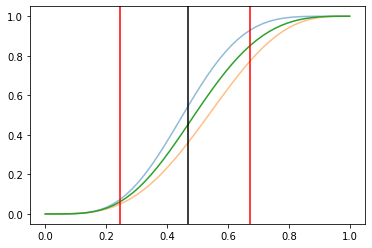

In [49]:
plt.plot(successes, beta_mixture.cdf(x), alpha=.5)
plt.plot(successes, beta_mixture.mean_cdf(x))

mode = beta_mixture.mean_mode()
upper, lower = beta_mixture.confidence_interval(0.8)
plt.axvline(mode, color='k')
plt.axvline(lower, color='r')
plt.axvline(upper, color='r')

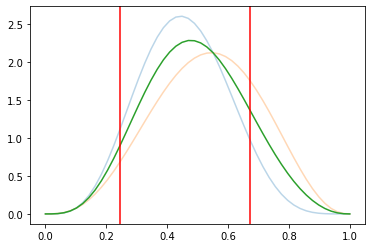

In [50]:

plt.plot(x, probs, alpha=.3)

mean_probs = beta_mixture.mean_prob(x)
plt.plot(x, mean_probs)
upper, lower = beta_mixture.confidence_interval(0.8)
plt.axvline(lower, color='r')
plt.axvline(upper, color='r')
plt.axvline(mode, color='k')
plt.xlabel('Concentration[0]')
plt.ylabel('')

In [51]:
beta = tfp.distributions.Beta(1.2, 1.4)

In [52]:
beta.prob(x)

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.        , 0.7991447 , 0.91027814, 0.9787153 , 1.0276045 ,
       1.0648885 , 1.0943258 , 1.1180168 , 1.137262  , 1.1529262 ,
       1.1656144 , 1.1757662 , 1.1837118 , 1.1897035 , 1.1939381 ,
       1.1965721 , 1.1977291 , 1.197509  , 1.1959918 , 1.1932412 ,
       1.1893077 , 1.1842301 , 1.1780374 , 1.1707494 , 1.1623777 ,
       1.1529263 , 1.1423912 , 1.1307611 , 1.1180168 , 1.1041311 ,
       1.0890673 , 1.0727793 , 1.0552094 , 1.0362865 , 1.0159242 ,
       0.99401706, 0.97043604, 0.945022  , 0.91757774, 0.88785493,
       0.8555355 , 0.82020384, 0.7813005 , 0.73804563, 0.6892989 ,
       0.63327986, 0.5669294 , 0.48412842, 0.36844888, 0.        ],
      dtype=float32)>

In [53]:
beta.cdf(x)

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.        , 0.01364217, 0.03119951, 0.05051949, 0.07101663,
       0.0923844 , 0.11442844, 0.13701184, 0.16003162, 0.18340638,
       0.2070696 , 0.23096524, 0.25504512, 0.27926677, 0.3035926 ,
       0.32798806, 0.35242203, 0.37686563, 0.40129125, 0.42567316,
       0.44998696, 0.47420853, 0.49831527, 0.5222845 , 0.5460937 ,
       0.56972104, 0.5931446 , 0.61634177, 0.63929045, 0.66196734,
       0.68434894, 0.70641077, 0.7281271 , 0.7494713 , 0.7704148 ,
       0.7909271 , 0.8109755 , 0.8305243 , 0.84953403, 0.86796093,
       0.8857554 , 0.90286034, 0.9192089 , 0.93472064, 0.94929594,
       0.96280605, 0.97507447, 0.9858359 , 0.9946197 , 1.        ],
      dtype=float32)>

In [54]:
beta

<tfp.distributions.Beta 'Beta' batch_shape=[] event_shape=[] dtype=float32>

In [55]:
beta = tfp.distributions.Beta([1.2], [1.4])
beta.prob(x)  # supports batch shape 1 -> batch shape None

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.        , 0.7991447 , 0.91027814, 0.9787153 , 1.0276045 ,
       1.0648885 , 1.0943258 , 1.1180168 , 1.137262  , 1.1529262 ,
       1.1656144 , 1.1757662 , 1.1837118 , 1.1897035 , 1.1939381 ,
       1.1965721 , 1.1977291 , 1.197509  , 1.1959918 , 1.1932412 ,
       1.1893077 , 1.1842301 , 1.1780374 , 1.1707494 , 1.1623777 ,
       1.1529263 , 1.1423912 , 1.1307611 , 1.1180168 , 1.1041311 ,
       1.0890673 , 1.0727793 , 1.0552094 , 1.0362865 , 1.0159242 ,
       0.99401706, 0.97043604, 0.945022  , 0.91757774, 0.88785493,
       0.8555355 , 0.82020384, 0.7813005 , 0.73804563, 0.6892989 ,
       0.63327986, 0.5669294 , 0.48412842, 0.36844888, 0.        ],
      dtype=float32)>

In [56]:
beta.cdf(x)  # does not support batch shape 1 -> batch shape None

InvalidArgumentError: Shapes of a and x are inconsistent: [1] vs. [50] [Op:Betainc]